In [1]:
from google.colab import drive
drive.mount("/content/drive")
%cd "/content/drive/My Drive/UROP_Lee/"
%ls
import pandas as pd
import numpy as np
import sklearn
import seaborn as sns
from sklearn.preprocessing import StandardScaler
import itertools
from datetime import datetime
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.manifold import TSNE
from sklearn import metrics

Mounted at /content/drive
/content/drive/My Drive/UROP_Lee
 11_3_15_06.csv                                     Test3.csv
 11_3_15_06_pw.csv                                  Test4.csv
 11_3_15_17.csv                                     Test_data.csv
 11_3_15_17_pw.csv                                  Testing1.csv
 3_11_15_07.csv                                     Testing2.csv
 3_12_15_06.csv                                     Testing3.csv
 best_model.h5                                      Testing4.csv
 Machine_learning_for_polynomial_regression.ipynb   Train.csv
 Measured.csv                                       Train_data.csv
'New data'/                                         Trained_data_output.xlsx
 Other_machine_learning_approach.ipynb              Train_feature.txt
 Power_predcition_by_polynomial_regression.ipynb    Train_raw_data_with_labels.xlsx
 Predicted_value.csv                                train_raw_data.xlsx
 Target_value.csv                                   tuple_o

# Read files


In [3]:
M1 = pd.read_csv("New data/M1.CSV",encoding='ISO-8859-1')
M1_pw = pd.read_csv("New data/M1_pw.csv")
M2 = pd.read_csv("New data/M2.csv")
M2_pw = pd.read_csv("New data/M2_pw.csv")
M3 = pd.read_csv("New data/M3.CSV",encoding='ISO-8859-1')
M3_pw = pd.read_csv("New data/M3_pw.csv")
M4 = pd.read_csv("New data/M4.CSV",encoding='ISO-8859-1')
M4_pw = pd.read_csv("New data/M4_pw.csv")
M5 = pd.read_csv("New data/M5.CSV",encoding='ISO-8859-1')
M5_pw = pd.read_csv("New data/M5_pw.csv")
M6 = pd.read_csv("New data/M6.CSV",encoding='ISO-8859-1')
M6_pw = pd.read_csv("New data/M6_pw.csv")
M6 = pd.read_csv("New data/M6.CSV",encoding='ISO-8859-1')
M6_pw = pd.read_csv("New data/M6_pw.csv")
M7 = pd.read_csv("New data/M7.CSV",encoding='ISO-8859-1')
M7_pw = pd.read_csv("New data/M7_pw.csv")

T1 = pd.read_csv("New data/T1.csv",encoding='ISO-8859-1')
T1_pw = pd.read_csv("New data/T1_pw.csv")
T2 = pd.read_csv("New data/T2.csv",encoding='ISO-8859-1')
T2_pw = pd.read_csv("New data/T2_pw.csv")
T3 = pd.read_csv("11_3_15_17.csv",encoding='ISO-8859-1')
T3_pw = pd.read_csv("11_3_15_17_pw.csv")
T4 = pd.read_csv("11_3_15_06.csv",encoding='ISO-8859-1')
T4_pw = pd.read_csv("11_3_15_06_pw.csv")
T5 = pd.read_csv("New data/T3.CSV",encoding='ISO-8859-1')
T5_pw = pd.read_csv("New data/T3_pw.csv")
T6 = pd.read_csv("New data/T4.CSV",encoding='ISO-8859-1')
T6_pw = pd.read_csv("New data/T4_pw.csv")
T7 = pd.read_csv("New data/T5.CSV",encoding='ISO-8859-1')
T7_pw = pd.read_csv("New data/T5_pw.csv")
T8 = pd.read_csv("New data/T6.CSV",encoding='ISO-8859-1')
T8_pw = pd.read_csv("New data/T6_pw.csv")
T9 = pd.read_csv("New data/T7.CSV",encoding='ISO-8859-1')
T9_pw = pd.read_csv("New data/T7_pw.csv")

# Preprocess data


In [4]:
def custom_time_parser(s):
    # Filter out non-string type (due to NaNs in the data) and 'Time'
    if type(s) is not str or s == 'Time':
        return None

    # Split into time and the PM/AM
    time, modifier = s.split()
    # Split time into hours, minutes and seconds+milliseconds,
    hours, minutes, seconds = map(int, time.split(':'))
    # Split seconds into seconds and milliseconds
    term, milliseconds = modifier.split(':')
    milliseconds = int(milliseconds)
    # If it's PM, add 12 to the hour (but not if it's 12 PM)
    if modifier.upper() == 'PM' and hours != 12:
        hours += 12
    elif modifier.upper() == 'AM' and hours == 12:
        hours = 0
    return pd.Timestamp(2024,1,1,hours, minutes, seconds)

def custom_parser(s):
    # check if s is a float (possibly NaN)
    if isinstance(s, float):
        # if it is, return a pandas Not a Time (NaT) value
        return pd.NaT
    else:
        # check if s is 'Time'
        if s == 'Time':
            return pd.NaT
        else:
            # split timestamp into hours, minutes and seconds
            parts = s.split(":")
            # split the second into whole seconds and fractional seconds and then pad 0
            sec_parts = parts[2].split(".")
            hours = int(parts[0])
            minutes = int(parts[1])
            seconds = int(sec_parts[0])
            if hours > 12:
              hours -= 12
            elif hours == 0:
              hours = 12
            # convert the formatted time to datetime
            return pd.Timestamp(2024, 1, 1, hours, minutes, seconds)

def Average_for_one_second(d1, d1_t):
    d1_t = d1_t.rename(columns={'??(V)': 'voltage', '??(A)': 'ampere','??(W)':'watt','??.1':'Time','????':'factor'})
    ori = d1
    d1 = d1.iloc[:-2]
    d1_t['Time'] = d1_t['Time'].apply(custom_time_parser)
    d1['Time'] = d1['Time'].apply(custom_parser)

    cat = []
    # Iterating over each column
    for column in d1.columns:
      # Try to convert column to float type
      if column == 'Time':
        continue
      d1[column] = pd.to_numeric(d1[column], errors='ignore')

    d1 = d1.drop('Date', axis=1)
    d1 = d1.replace({'Yes': 1, 'No': 0})
    d1 = d1.groupby('Time').mean()
    d1_t = d1_t.groupby('Time').mean()
    result = d1.merge(d1_t['watt'], on='Time', how='inner')
    return result

In [13]:
ProcessedT1 = Average_for_one_second(T1, T1_pw)
ProcessedT2 = Average_for_one_second(T2, T2_pw)
ProcessedT3 = Average_for_one_second(T3, T3_pw)
ProcessedT4 = Average_for_one_second(T4, T4_pw)
ProcessedT5 = Average_for_one_second(T5, T5_pw)
ProcessedT6 = Average_for_one_second(T6, T6_pw)
ProcessedT7 = Average_for_one_second(T7, T7_pw)
ProcessedT8 = Average_for_one_second(T8, T8_pw)
ProcessedT9 = Average_for_one_second(T9, T9_pw)
#tricks for the data matching
ProcessedT1.columns = ProcessedT1.columns.str.replace('Â', '')
ProcessedT2.columns = ProcessedT2.columns.str.replace('Â', '')
ProcessedT3.columns = ProcessedT3.columns.str.replace('Â', '')
ProcessedT4.columns = ProcessedT4.columns.str.replace('Â', '')
ProcessedT5.columns = ProcessedT5.columns.str.replace('Â', '')
ProcessedT6.columns = ProcessedT6.columns.str.replace('Â', '')
ProcessedT7.columns = ProcessedT7.columns.str.replace('Â', '')
ProcessedT8.columns = ProcessedT8.columns.str.replace('Â', '')
ProcessedT9.columns = ProcessedT9.columns.str.replace('Â', '')



ProcessedM1 = Average_for_one_second(M1, M1_pw)
ProcessedM2 = Average_for_one_second(M2, M2_pw)
ProcessedM3 = Average_for_one_second(M3, M3_pw)
ProcessedM4 = Average_for_one_second(M4, M4_pw)
ProcessedM5 = Average_for_one_second(M5, M5_pw)
ProcessedM6 = Average_for_one_second(M6, M6_pw)
ProcessedM7 = Average_for_one_second(M7, M7_pw)

ProcessedM1['Source'] = 'ProcessedM1'
ProcessedM2['Source'] = 'ProcessedM2'
ProcessedM3['Source'] = 'ProcessedM3'
ProcessedM4['Source'] = 'ProcessedM4'
ProcessedM5['Source'] = 'ProcessedM5'
ProcessedM6['Source'] = 'ProcessedM6'
ProcessedM7['Source'] = 'ProcessedM7'

frames = [ProcessedM1, ProcessedM2, ProcessedM3, ProcessedM4, ProcessedM5, ProcessedM6, ProcessedM7, ProcessedT1, ProcessedT2, ProcessedT3, ProcessedT4]

df_big = pd.concat(frames, ignore_index=True)
print(df_big.shape)

<ipython-input-4-dc6bae4b0193>:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  d1['Time'] = d1['Time'].apply(custom_parser)
<ipython-input-4-dc6bae4b0193>:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  d1[column] = pd.to_numeric(d1[column], errors='ignore')
<ipython-input-4-dc6bae4b0193>:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/p

(5023, 233)


# Model trained


In [6]:
def pre_process_model(df,Selected_features,power):
  New_df = pd.DataFrame({})
  df = df.reset_index(drop=True)


  for feature in Selected_features:
      # Check if the feature name contains "[°C]"
      if '[°C]' in feature:
          # Subtract 'Ambient [°C]' feature value from the selected feature
          df[feature] = (df[feature]+273)/(df['Ambient [°C]']+273)
          print(feature,'_updated')
  #Power each feature to some power
  for feature in Selected_features:
    for i in range(power):
        New_df['Combined_feature_'+feature+'_'+'Power to the_'+str(i+1)] = df[feature]**(i+1)
    New_df['Combined_feature_log'+feature] = np.log(df[feature]+1)

  #Times things altogether
  shape = df.shape[0]
  Combined_series = pd.Series(np.ones(shape))
  for thing in Selected_features:
    Combined_series = Combined_series * df[thing]

  Combinations = list(itertools.combinations(Selected_features, 2))
  for thing in Combinations:
    for i in range(power-1):
      New_df[thing[0]+'_power_'+str(i+1)+thing[1]+'_power_'+str(power-i-1)] = df[thing[0]]**(i+1)*df[thing[1]]**(power-i-1)

  New_df['Combined_Series'] = Combined_series
  New_df['target_feature'] = df['watt']

# Fill NaN values with the mean of the respective column
  New_df = New_df.fillna(New_df.ffill().bfill())
  return New_df

df_train = pre_process_model(df_big,['GPU Utilization [%]','Core Usage (avg) [%]','Core Temperatures (avg) [°C]','CPU GT Cores (Graphics) [°C]'],6)

Core Temperatures (avg) [°C] _updated
CPU GT Cores (Graphics) [°C] _updated


In [7]:
X = df_train.drop('target_feature',axis = 1)
labels = df_train['target_feature']

# Splitting the data into training and testing set
features_train, features_test, labels_train, labels_test = train_test_split(X, labels, test_size=0.2, random_state=0)

# Initialize the Linear Regression model
model = LinearRegression()

# Fit the model to the training data
model.fit(features_train, labels_train)

# Making predictions on the testing set
predictions = model.predict(features_test)

# To see the values of the coefficients created by the linear regression model
print('Coefficients: ', model.coef_)

# The mean squared error
print("Mean squared error: %.2f" % metrics.mean_squared_error(labels_test, predictions))

Coefficients:  [-1.67868046e+00  1.70616624e-01 -7.98242013e-03  1.53840049e-04
 -1.10267564e-06  1.27080613e-09  8.75630897e+00  2.96066787e+00
  2.69005067e-02 -1.75445609e-03  1.66632373e-05  4.53196735e-08
 -7.99342688e-10 -3.18009186e+01  1.68191125e+02  3.33762958e+02
  4.59110452e+02  5.03102941e+02  4.20695805e+02  1.62930491e+02
  8.29204260e+01 -1.01723990e+03 -1.49950870e+03 -1.44725599e+03
 -8.61934590e+02  2.53932503e+02  1.89668267e+03 -5.75494787e+02
  1.39364353e-10 -5.05524400e-10  8.93500829e-10 -5.10750109e-10
  1.42883927e-10 -4.38974261e+00  4.99260051e-01 -2.35566780e-02
  4.95970546e-04 -4.66564984e-06  3.13134090e+00 -4.80345904e-01
  2.57371609e-02 -5.63820853e-04  5.20290882e-06 -3.95865734e+00
  7.28495642e-01 -3.01357417e-02  5.37724329e-04 -4.37275074e-06
  8.66245544e+00 -1.04986702e+00  3.84965536e-02 -6.31332872e-04
  4.74737226e-06  8.43875039e+02 -1.08233515e+01 -5.91174569e+02
 -8.15309415e+02 -5.95359989e+02 -2.33898113e-03]
Mean squared error: 42.14

# Model output


Average difference between prediction and actual target_feature: -0.007611239495041389


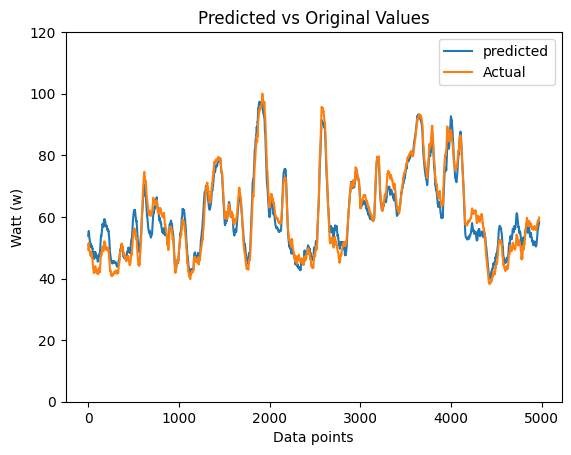

In [9]:
def smooth(data, window_size):
    return [sum(data[i-window_size+1:i+1])/window_size for i in range(window_size-1, len(data))]

def plotting_prediction(df_train):
  prediction = model.predict(df_train.drop('target_feature',axis=1))
    # Calculate difference between prediction and actual target_feature
  difference = prediction.mean() - df_train['target_feature'].mean()
  print('Average difference between prediction and actual target_feature:', difference)
  # Plot the predicted values against the actual ones
  plt.plot(smooth(prediction,51),label = "predicted")
  plt.plot(smooth(df_train['target_feature'],51),label = "Actual")

  plt.title('Predicted vs Original Values')
  plt.xlabel('Data points')
  plt.ylabel('Watt (w)')
  plt.legend()
  plt.ylim([0,120])
  plt.show()

plotting_prediction(df_train)

Core Temperatures (avg) [°C] _updated
CPU GT Cores (Graphics) [°C] _updated
Core Temperatures (avg) [°C] _updated
CPU GT Cores (Graphics) [°C] _updated
Core Temperatures (avg) [°C] _updated
CPU GT Cores (Graphics) [°C] _updated
Core Temperatures (avg) [°C] _updated
CPU GT Cores (Graphics) [°C] _updated
Core Temperatures (avg) [°C] _updated
CPU GT Cores (Graphics) [°C] _updated
Core Temperatures (avg) [°C] _updated
CPU GT Cores (Graphics) [°C] _updated
Core Temperatures (avg) [°C] _updated
CPU GT Cores (Graphics) [°C] _updated
Core Temperatures (avg) [°C] _updated
CPU GT Cores (Graphics) [°C] _updated
Core Temperatures (avg) [°C] _updated
CPU GT Cores (Graphics) [°C] _updated
Average difference between prediction and actual target_feature: 3.079090824656056


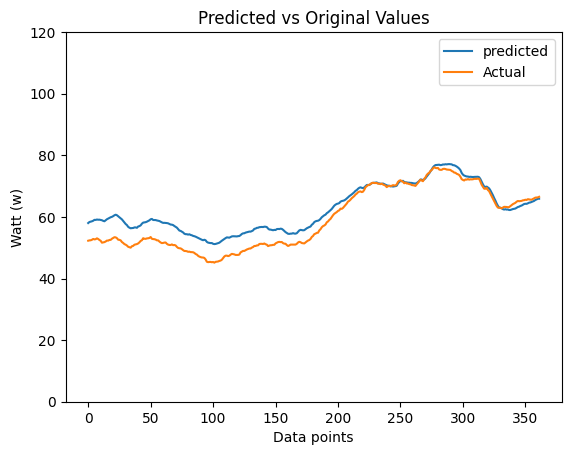

Average difference between prediction and actual target_feature: 1.4557130020164806


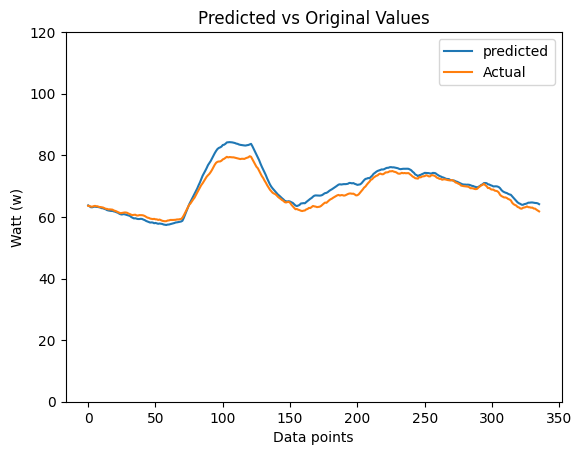

Average difference between prediction and actual target_feature: -2.3322169546659097


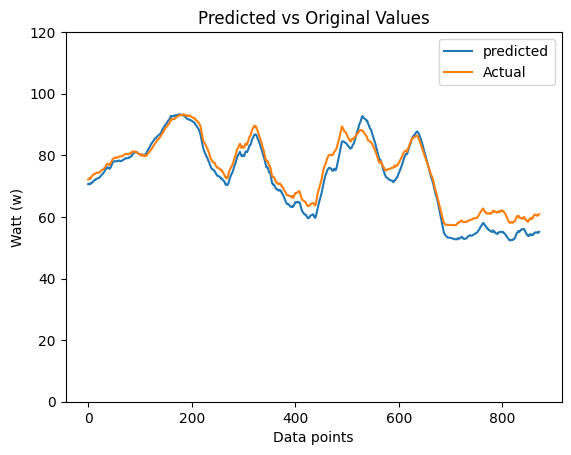

Average difference between prediction and actual target_feature: 1.744982033552958


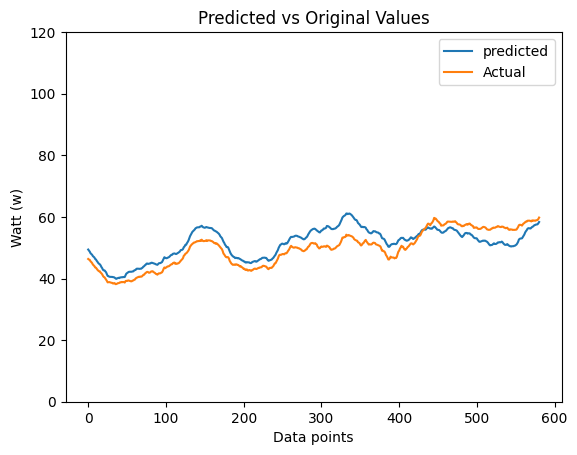

Average difference between prediction and actual target_feature: 2.3121109197846863


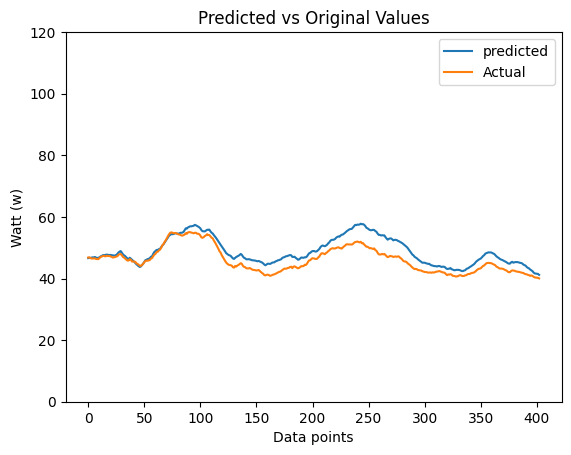

Average difference between prediction and actual target_feature: 2.7675118069755555


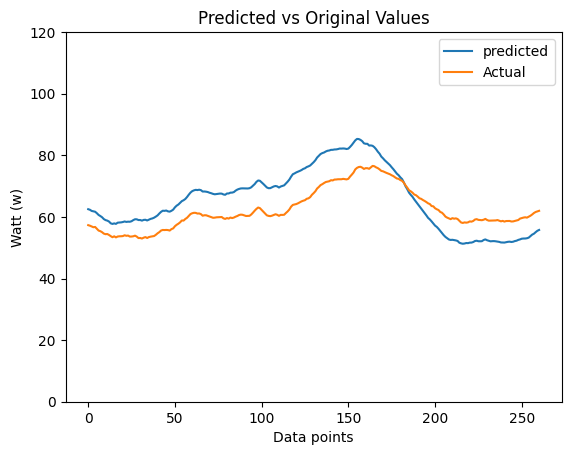

Average difference between prediction and actual target_feature: -6.230622660624263


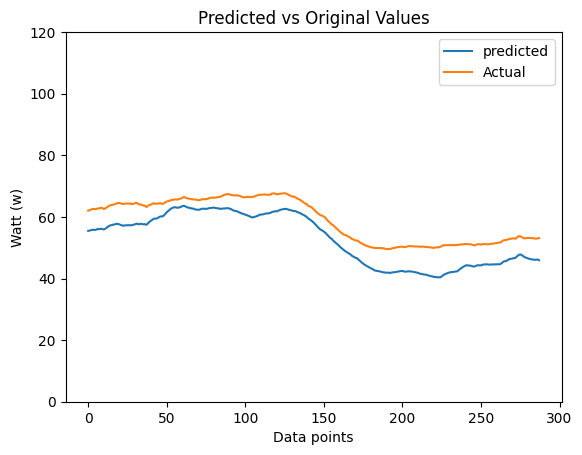

Average difference between prediction and actual target_feature: -3.8698618110286134


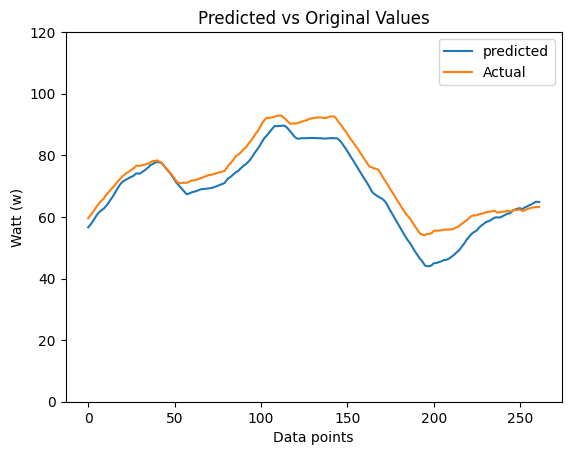

Average difference between prediction and actual target_feature: -4.621716073437931


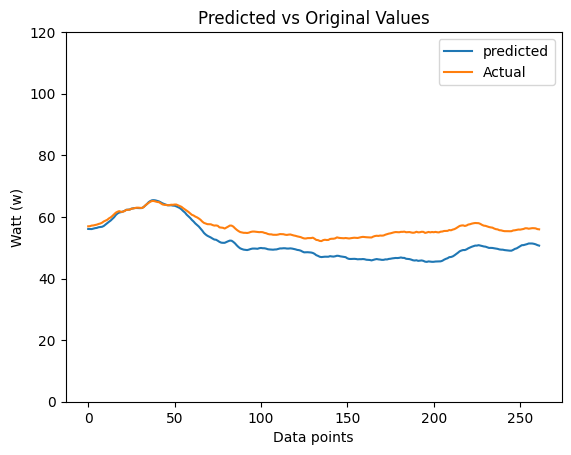

In [14]:
Validation1 = pre_process_model(ProcessedT1,['GPU Utilization [%]','Core Usage (avg) [%]','Core Temperatures (avg) [°C]','CPU GT Cores (Graphics) [°C]'],6)
Validation2 = pre_process_model(ProcessedT2,['GPU Utilization [%]','Core Usage (avg) [%]','Core Temperatures (avg) [°C]','CPU GT Cores (Graphics) [°C]'],6)
Validation3 = pre_process_model(ProcessedT3,['GPU Utilization [%]','Core Usage (avg) [%]','Core Temperatures (avg) [°C]','CPU GT Cores (Graphics) [°C]'],6)
Validation4 = pre_process_model(ProcessedT4,['GPU Utilization [%]','Core Usage (avg) [%]','Core Temperatures (avg) [°C]','CPU GT Cores (Graphics) [°C]'],6)
Validation5 = pre_process_model(ProcessedT5,['GPU Utilization [%]','Core Usage (avg) [%]','Core Temperatures (avg) [°C]','CPU GT Cores (Graphics) [°C]'],6)
Validation6 = pre_process_model(ProcessedT6,['GPU Utilization [%]','Core Usage (avg) [%]','Core Temperatures (avg) [°C]','CPU GT Cores (Graphics) [°C]'],6)
Validation7 = pre_process_model(ProcessedT7,['GPU Utilization [%]','Core Usage (avg) [%]','Core Temperatures (avg) [°C]','CPU GT Cores (Graphics) [°C]'],6)
Validation8 = pre_process_model(ProcessedT8,['GPU Utilization [%]','Core Usage (avg) [%]','Core Temperatures (avg) [°C]','CPU GT Cores (Graphics) [°C]'],6)
Validation9 = pre_process_model(ProcessedT9,['GPU Utilization [%]','Core Usage (avg) [%]','Core Temperatures (avg) [°C]','CPU GT Cores (Graphics) [°C]'],6)

plotting_prediction(Validation1)
plotting_prediction(Validation2)
plotting_prediction(Validation3)
plotting_prediction(Validation4)
plotting_prediction(Validation5)
plotting_prediction(Validation6)
plotting_prediction(Validation7)
plotting_prediction(Validation8)
plotting_prediction(Validation9)